<a href="https://colab.research.google.com/github/anomaitech/GeoApp/blob/main/C5_Cell_Phone_Tower_Placement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas
!apt-get install -y libgdal-dev
!pip install rasterio

In [1]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
from google.colab import files

In [2]:
# Upload your shapefiles and raster data
uploaded = files.upload()

Saving UtahCountyBoundary.dbf to UtahCountyBoundary.dbf
Saving UtahCountyBoundary.prj to UtahCountyBoundary.prj
Saving UtahCountyBoundary.sbn to UtahCountyBoundary.sbn
Saving UtahCountyBoundary.sbx to UtahCountyBoundary.sbx
Saving UtahCountyBoundary.shp to UtahCountyBoundary (1).shp
Saving UtahCountyBoundary.shp.xml to UtahCountyBoundary.shp.xml
Saving UtahCountyBoundary.shx to UtahCountyBoundary (1).shx
Saving UtahCountyCellularTowers.dbf to UtahCountyCellularTowers.dbf
Saving UtahCountyCellularTowers.prj to UtahCountyCellularTowers.prj
Saving UtahCountyCellularTowers.sbn to UtahCountyCellularTowers.sbn
Saving UtahCountyCellularTowers.sbx to UtahCountyCellularTowers.sbx
Saving UtahCountyCellularTowers.shp to UtahCountyCellularTowers (1).shp
Saving UtahCountyCellularTowers.shx to UtahCountyCellularTowers (2).shx
Saving UtahCountyDEM.tfw to UtahCountyDEM.tfw
Saving UtahCountyDEM.tif to UtahCountyDEM (1).tif
Saving UtahCountyDEM.tif.aux.xml to UtahCountyDEM.tif.aux.xml
Saving UtahCountyD

In [3]:
utah_county = gpd.read_file('/content/UtahCountyBoundary.shp').to_crs(epsg=26912)

# Load UDOT highways shapefile
highways = gpd.read_file('/content/UtahCountyMajorRoads.shp').to_crs(epsg=26912)

# Load cell tower shapefile
cell_towers = gpd.read_file('/content/UtahCountyCellularTowers.shp').to_crs(epsg=26912)

<ipython-input-24-b12a6344be69>:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


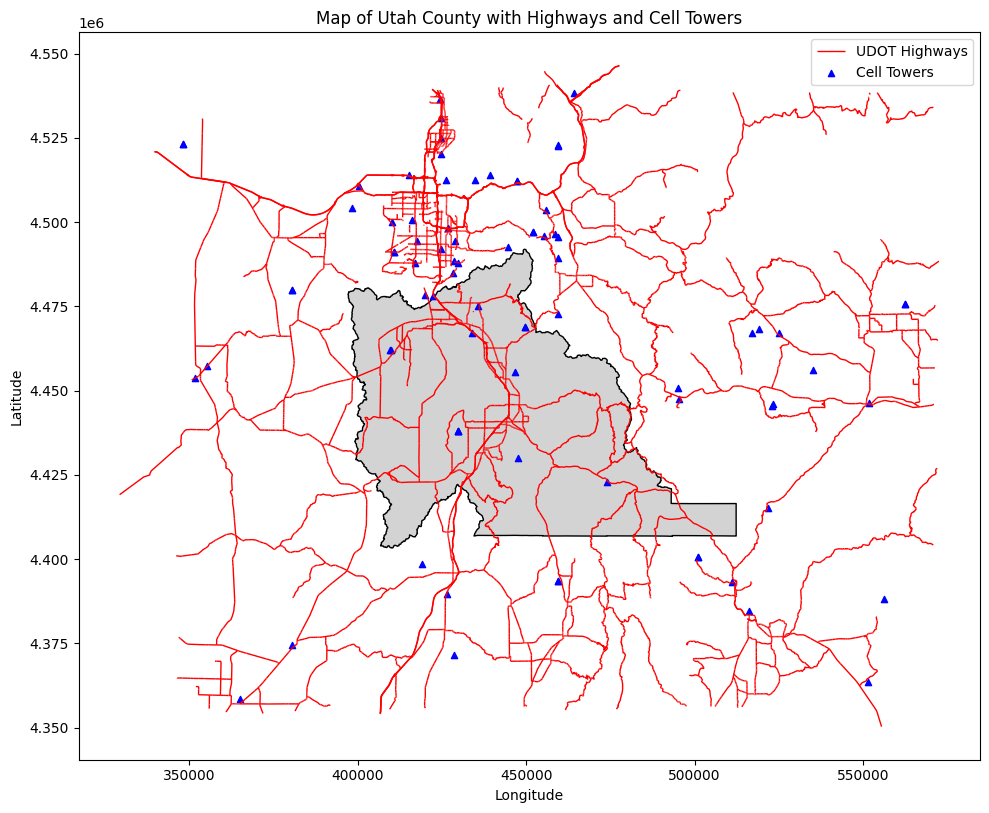

In [24]:
# prompt: create a map of the above three together

# Create the map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Utah county boundary
utah_county.plot(ax=ax, color='lightgray', edgecolor='black', label='Utah County')

# Plot highways
highways.plot(ax=ax, color='red', linewidth=1, label='UDOT Highways')

# Plot cell towers
cell_towers.plot(ax=ax, color='blue', markersize=20, marker='^', label='Cell Towers')


# Customize the map
ax.set_title('Map of Utah County with Highways and Cell Towers')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.tight_layout()
plt.show()


In [4]:
utah_county_buffer = utah_county.buffer(80467)  # 50 miles in meters
utah_county_buffer_gdf = gpd.GeoDataFrame(geometry=utah_county_buffer, crs='EPSG:26912')

<ipython-input-27-c921fc1ab6ed>:25: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


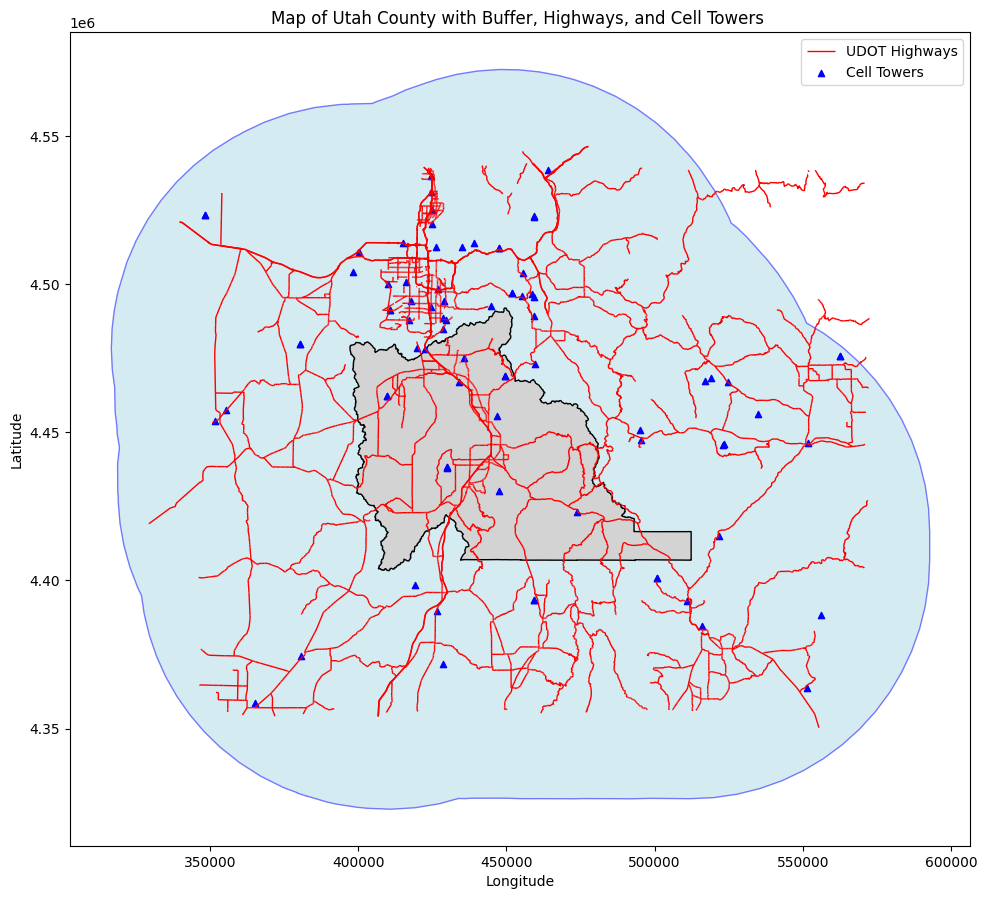

In [27]:

# Create the map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the buffered Utah county boundary
utah_county_buffer_gdf.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.5, label='Utah County Buffer (50 miles)')

# Plot Utah county boundary
utah_county.plot(ax=ax, color='lightgray', edgecolor='black', label='Utah County')

# Plot highways
highways.plot(ax=ax, color='red', linewidth=1, label='UDOT Highways')

# Plot cell towers
cell_towers.plot(ax=ax, color='blue', markersize=20, marker='^', label='Cell Towers')


# Customize the map
ax.set_title('Map of Utah County with Buffer, Highways, and Cell Towers ')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.tight_layout()
plt.show()


In [5]:
cell_towers_clipped = gpd.clip(cell_towers, utah_county_buffer_gdf)


In [6]:
highways_buffer = highways.buffer(1000, resolution=16)  # 1 km buffer
highways_buffer_gdf = gpd.GeoDataFrame(geometry=highways_buffer, crs='EPSG:26912')
highways_buffer_dissolved = highways_buffer_gdf.dissolve()  # Dissolve overlapping buffers

<ipython-input-28-4492c31eb15b>:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


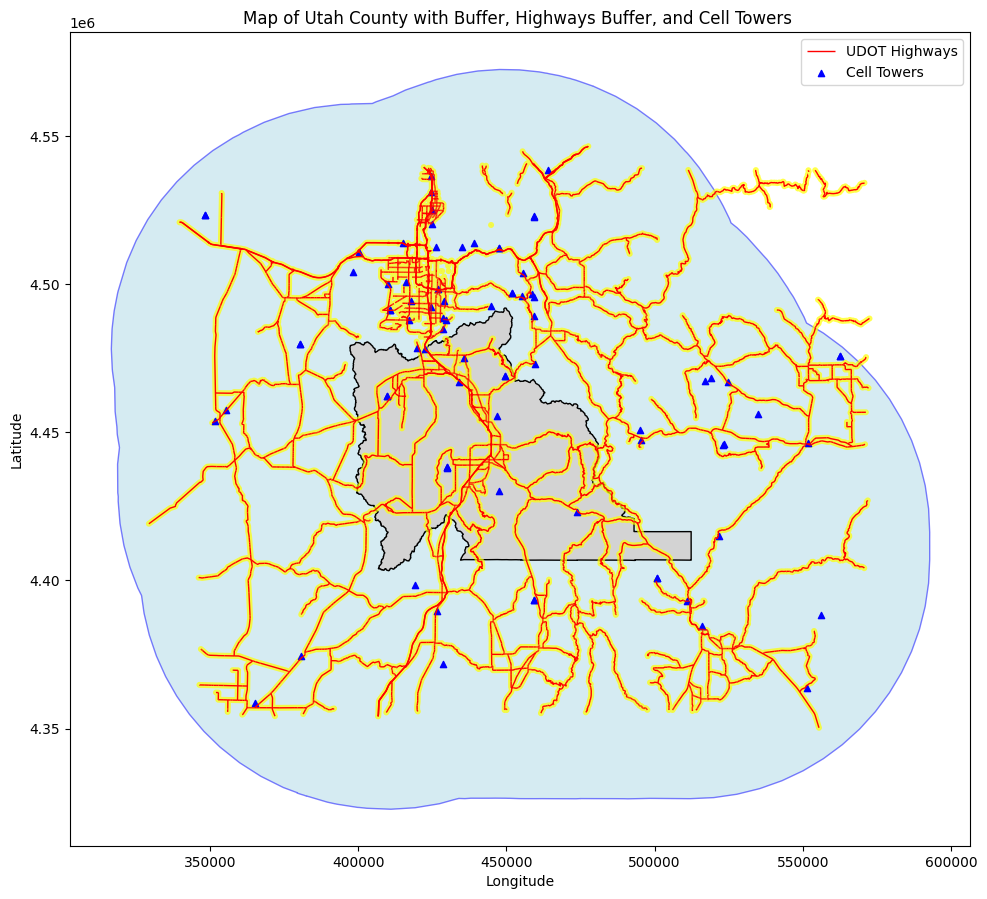

In [28]:
# prompt: include highways_buffer to the map

# Create the map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the buffered Utah county boundary
utah_county_buffer_gdf.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.5, label='Utah County Buffer (50 miles)')

# Plot Utah county boundary
utah_county.plot(ax=ax, color='lightgray', edgecolor='black', label='Utah County')

# Plot highways buffer
highways_buffer_dissolved.plot(ax=ax, color='yellow', alpha=0.7, label='Highways Buffer (1km)')

# Plot highways
highways.plot(ax=ax, color='red', linewidth=1, label='UDOT Highways')

# Plot cell towers
cell_towers.plot(ax=ax, color='blue', markersize=20, marker='^', label='Cell Towers')


# Customize the map
ax.set_title('Map of Utah County with Buffer, Highways Buffer, and Cell Towers ')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.tight_layout()
plt.show()


In [7]:
# Open the NED raster
dem = rasterio.open('/content/UtahCountyDEM.tif')

# Calculate slope using gdal
gdal.DEMProcessing('slope.tif', dem.name, 'slope', computeEdges=True)
slope = rasterio.open('slope.tif')

# Create a binary mask for slopes < 5 degrees
with slope as src:
    slope_data = src.read(1)
    suitable_slope = (slope_data < 5).astype(int)  # 1 for < 5°, 0 otherwise

In [8]:
with rasterio.open('slope.tif') as src:
    out_image, out_transform = mask(src, highways_buffer_dissolved.geometry, crop=True)
    out_meta = src.meta.copy()
    out_image = (out_image[0] < 5).astype(int)  # 1 for suitable slopes within buffers

# Save the intermediate raster
out_meta.update({"driver": "GTiff", "height": out_image.shape[0], "width": out_image.shape[1], "transform": out_transform})
with rasterio.open('suitable_slopes.tif', 'w', **out_meta) as dest:
    dest.write(out_image, 1)

<ipython-input-30-f6518d2c6732>:34: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


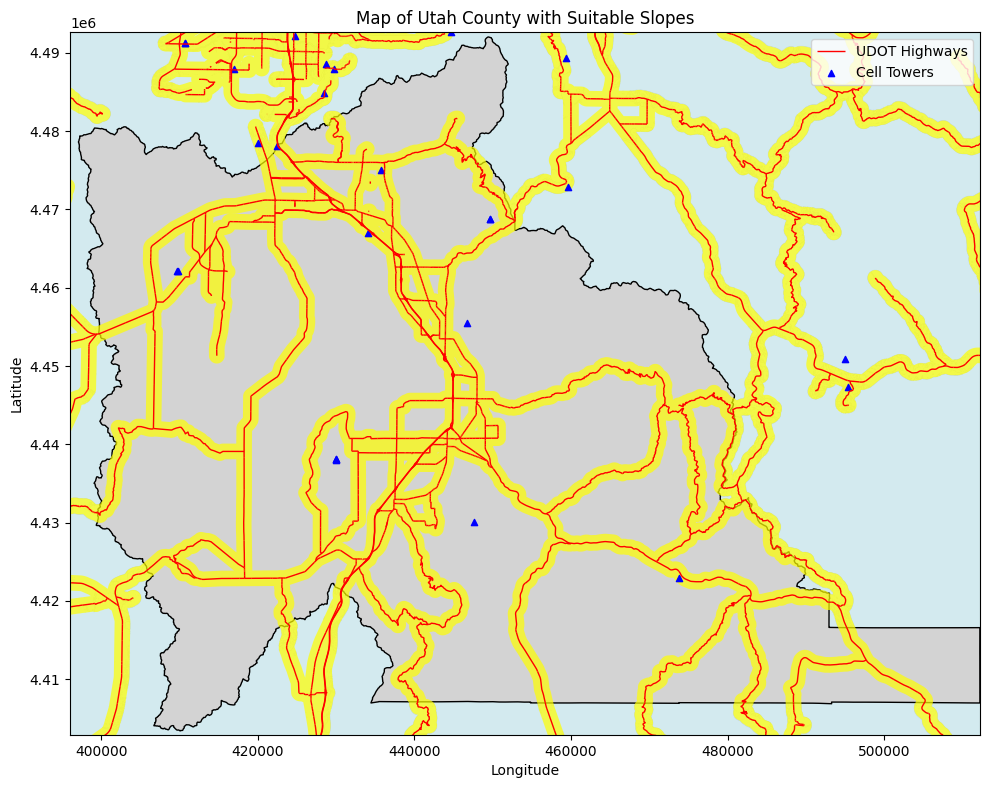

In [30]:
# prompt: map suitable slope

# Assuming 'suitable_slopes.tif' is created as in the previous code

# Now you can use the 'suitable_slopes.tif' raster to visualize suitable slopes
suitable_slopes_raster = rasterio.open('suitable_slopes.tif')

# Create the map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the buffered Utah county boundary
utah_county_buffer_gdf.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.5, label='Utah County Buffer (50 miles)')

# Plot Utah county boundary
utah_county.plot(ax=ax, color='lightgray', edgecolor='black', label='Utah County')

# Plot highways buffer
highways_buffer_dissolved.plot(ax=ax, color='yellow', alpha=0.7, label='Highways Buffer (1km)')

# Plot highways
highways.plot(ax=ax, color='red', linewidth=1, label='UDOT Highways')

# Plot cell towers
cell_towers.plot(ax=ax, color='blue', markersize=20, marker='^', label='Cell Towers')

# Plot the suitable slopes raster
show(suitable_slopes_raster, ax=ax, cmap='Greens', alpha=0.5, title='Suitable Slopes (<5 degrees)')


# Customize the map
ax.set_title('Map of Utah County with Suitable Slopes')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.tight_layout()
plt.show()


In [14]:
from rasterio.features import rasterize
from rasterio.transform import from_bounds

# Define raster bounds and resolution (200m cell size)
bounds = utah_county_buffer_gdf.total_bounds
width = int((bounds[2] - bounds[0]) / 200)
height = int((bounds[3] - bounds[1]) / 200)
transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], width, height)

# Rasterize cell towers (count per cell)
tower_raster = rasterize(
    [(geom, 1) for geom in cell_towers_clipped.geometry],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype='float32'
)

# Calculate density (towers per sq km, then scale to 10,000 sq km)
density = tower_raster / (0.2 * 0.2)  # 200m x 200m = 0.04 sq km per cell
density_10000 = density * 10000  # Scale to 10,000 sq km
low_density = (density_10000 < 20).astype(int)  # 1 where < 20 towers/10,000 sq km

# Save density raster
density_meta = {'driver': 'GTiff', 'height': height, 'width': width, 'count': 1, 'dtype': 'int32', 'crs': 'EPSG:26912', 'transform': transform}
with rasterio.open('low_density.tif', 'w', **density_meta) as dest:
    dest.write(low_density, 1)

In [21]:
with rasterio.open('suitable_slopes.tif') as slope_src, rasterio.open('low_density.tif') as density_src:
    # Reproject density raster to match slope raster's CRS and resolution
    density_data = density_src.read(
        1,
        out_shape=slope_src.shape,
        resampling=rasterio.enums.Resampling.nearest,  # Choose appropriate resampling method
    )

    # Apply transform to the density data
    density_data = rasterio.warp.reproject(
        density_data,
        destination=np.empty(slope_src.shape, dtype=density_data.dtype), # Create an empty array to store the reprojected data
        src_transform=density_src.transform,
        src_crs=density_src.crs,
        dst_transform=slope_src.transform,
        dst_crs=slope_src.crs,
        resampling=rasterio.enums.Resampling.nearest
    )[0] # Get the reprojected data from the output tuple

    slope_data = slope_src.read(1)
    # Now, perform the multiplication
    final_suitable = slope_data * density_data

    # Save final raster
    final_meta = slope_src.meta.copy()
    with rasterio.open('final_suitable.tif', 'w', **final_meta) as dest:
        dest.write(final_suitable, 1)

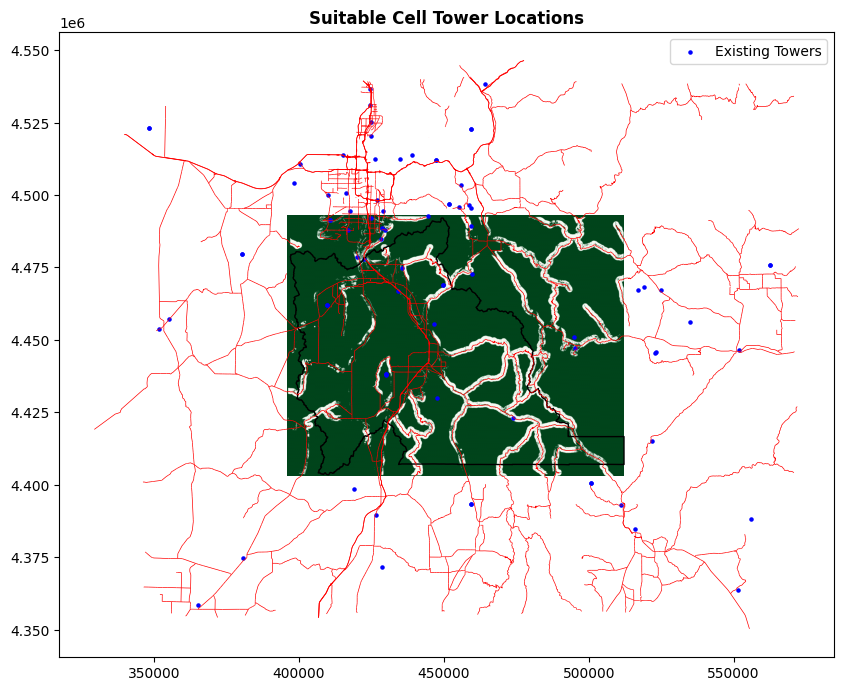

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
with rasterio.open('final_suitable.tif') as src:
    show(src, ax=ax, cmap='Greens', title='Suitable Cell Tower Locations')
utah_county.boundary.plot(ax=ax, color='black', linewidth=1)
highways.plot(ax=ax, color='red', linewidth=0.5)
cell_towers_clipped.plot(ax=ax, color='blue', markersize=5, label='Existing Towers')
plt.legend()
plt.show()